In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from pprint import pprint

In [59]:
pd.set_option('display.max_columns', None)

In [60]:
data = pd.read_excel('data/data.xlsx')

In [61]:
data.head()

,client_id,loan_currency,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,type_of_product,status_of_loan,location,emirates,gender,age,family_status,monthly_income_aed,quantity_of_prior_loans_at_cbi,employment_sphere,employment_level,work_experience,presence_of_car,presence_of_housing,coborrower,collateral,top_up,dsr
0,4964,AED,174400.0,2020-02-26,2025-02-28,60,0.0549,3,3,10,CAR LOAN,Active,UNITED ARAB EMIRATES,DXB Rigga Road BR,Female,51,MARRIED,78096.43,10,Personal salary,MANAGER,5 Years 0 Months,1,0,No,No,No,NaN
1,5331,AED,100000.0,2021-11-16,2026-11-26,60,0.0300,6,11,9,CAR LOAN,Active,UNITED ARAB EMIRATES,DXB Rigga Road BR,Male,59,MARRIED,204166.66,9,Personal salary,PARTNER,19 Years 1 Months,1,0,No,No,No,NaN
2,5214,AED,180000.0,2021-11-24,2024-12-10,36,0.0457,0,0,0,CAR LOAN,Active,JORDAN,DXB Rigga Road BR,Male,45,MARRIED,15000.00,0,Personal salary,MANAGING DIRECTOR,4 Years 3 Months,1,0,No,No,No,NaN
3,4996,AED,171999.0,2018-11-08,2024-06-26,68,0.0686,6,15,4,CAR LOAN,Active,JORDAN,DXB Rigga Road BR,Male,49,MARRIED,50000.00,4,Personal salary,MANAGER,4 Years -4 Months,1,0,No,No,No,49.21
4,5153,AED,50000.0,2021-12-08,2025-11-27,48,0.0457,0,0,5,CAR LOAN,Active,UNITED ARAB EMIRATES,RAK Julphar BR,Male,56,MARRIED,72167.00,5,Personal (Non business),OTHERS,36 Years 4 Months,4,1,No,No,No,NaN


## Data cleaning and feature selection

In [62]:
# Adding monthly Macro-variables #
macro = pd.read_excel('data/UAE_Monthly1.xlsx')
macro['DateTime'] = macro['DateTime'].astype('datetime64')

data['inflation_rate'] = np.zeros(len(data))
data['manufacturing_PMI'] = np.zeros(len(data))

for i in data.index:
    for j in macro.index:
        if data.loc[i, 'date_of_disbursement'].year == macro.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro.loc[j, 'DateTime'].month:
            data.at[i, 'inflation_rate']    = macro.loc[j, 'Inflation Rate']
            data.at[i, 'manufacturing_PMI'] = macro.loc[j, 'Manufacturing PMI']
            break

In [63]:
# Adding quarterly Macro-variables #
macro2 = pd.read_excel('data/UAE_quarter1.xlsx')
macro2['DateTime'] = macro2['DateTime'].astype('datetime64')

data['CPI'] = [ np.nan for i in data.index]

for i in data.index:
    for j in macro2.index:
        if data.loc[i, 'date_of_disbursement'].year == macro2.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro2.loc[j, 'DateTime'].month:
            data.at[i, 'CPI'] = macro2.loc[j, 'Consumer Price Index CPI']
            break

In [64]:
data_macro = data.copy()

---

In [65]:
# Creating target columns #
data_macro['max_90_bad'] = (data_macro['max_dpd_3_year'] >= 90).astype(int)
data_macro['cmltv_90_bad'] = (data_macro['cumulative_days_of_late_payments_throughout_loan_repayments'] >= 90).astype(int)

print(data_macro['cmltv_90_bad'].value_counts())

0    2646
1     543
Name: cmltv_90_bad, dtype: int64


In [66]:
target = 'cmltv_90_bad'

cat_feats = [
    'location',
    'emirates',
    'gender',
    'family_status',
    'employment_sphere',
    'collateral',
    'type_of_product',
    'employment_level'
]
num_feats = [
    'loan_amount',
    'duration_at_disbursement_months',
    'interest_rate',
    'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
    'age',
    'monthly_income_aed',
    'work_experience',
    'inflation_rate',
    'manufacturing_PMI',
    'presence_of_car',
    'presence_of_housing',
    'CPI'
]

ignore_feats = [
    'client_id',
    'loan_currency',
    'date_of_disbursement',
    'date_of_closure_based_on_contract',
    'max_dpd_3_year',
    'cumulative_days_of_late_payments_throughout_loan_repayments',
    'status_of_loan',
    'quantity_of_prior_loans_at_cbi',
    'coborrower',
    'top_up',
    'dsr',
    'max_90_bad'
]

In [67]:
data_macro.isna().sum()

client_id                                                        0
loan_currency                                                    0
loan_amount                                                      0
date_of_disbursement                                             0
date_of_closure_based_on_contract                                0
duration_at_disbursement_months                                  0
interest_rate                                                    0
max_dpd_3_year                                                   0
cumulative_days_of_late_payments_throughout_loan_repayments      0
quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi       0
type_of_product                                                  0
status_of_loan                                                   0
location                                                         0
emirates                                                         0
gender                                                        

In [68]:
def isnan(num):
    return num != num

# Converting Work experience feature to the months #
for i in data_macro.index:
    it = data_macro.loc[i, 'work_experience']
    years, months, gap, minus = 0, 0, False, False

    if isnan(it):
        continue
    
    # Extracting year and month from the string #
    for j in it :
        if j >= '0' and j <= '9' :
            if not gap :
                years = years*10 + int(j)
            else :
                months = months*10 + int(j)
        elif j == '-' :
            minus = True
            gap = True
        else :
            gap = True
    # Setting the new value to the DataFrame #
    if minus :
        months *= -1
        
    data_macro.at[i, 'work_experience'] = int(years*12 + months)
    
data_macro['work_experience'] = data_macro['work_experience'].astype('float32')

In [69]:
data_macro[data_macro['work_experience'].isna()][['loan_currency', 'interest_rate', 'work_experience']]

,loan_currency,interest_rate,work_experience
85,AED,0.068444,NaN
143,AED,0.080508,NaN
2097,AED,0.045000,NaN
2536,AED,0.120000,NaN


In [70]:
data_na = data_macro.dropna(subset=cat_feats+num_feats)

---

In [71]:
# Choosing only Closed loans & Active loans that are already bad #
data_closed_or_bad = data_na[(data_na['status_of_loan'] == 'Active') & (data_na[target] == 1) | (data_na['status_of_loan'] != 'Active')]

In [72]:
data_closed_or_bad.drop(columns=["loan_currency"], inplace=True)
ignore_feats.remove('loan_currency')

In [73]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_closed_or_bad, train_size=0.8, random_state=89, stratify=data_closed_or_bad[target])

In [74]:
# Target mean encoding #
cols = cat_feats

for col in cols:
    stats = train[target].groupby(train[col]).agg(['count', 'mean'])
    train[col+'_mean_encoded'] = train[col].copy()
    test[col+'_mean_encoded'] = test[col].copy()
    
    for i in train[col+'_mean_encoded'].unique():
        train[col+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)        
        test[col+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)

In [75]:
# Removing classes that are in test set but not in train set #
for i in test.index:
    for col in cat_feats:
        if type(test[col+'_mean_encoded'][i]) == str:
            test.drop(i,inplace=True)
            break

In [76]:
# We move all categorical variables to numerical list #
for i in cat_feats:
    num_feats.extend( [i+'_mean_encoded'] )
    ignore_feats.extend([i])

cat_feats.clear()

In [77]:
train[train['employment_level'] == 'ADMINISTRATOR'][['employment_level', 'employment_level_mean_encoded']]

,employment_level,employment_level_mean_encoded
1378,ADMINISTRATOR,0.241379
741,ADMINISTRATOR,0.241379
2929,ADMINISTRATOR,0.241379
1872,ADMINISTRATOR,0.241379
2631,ADMINISTRATOR,0.241379
2779,ADMINISTRATOR,0.241379
2018,ADMINISTRATOR,0.241379
2134,ADMINISTRATOR,0.241379
1009,ADMINISTRATOR,0.241379
2962,ADMINISTRATOR,0.241379


In [78]:
stats

,count,mean
employment_level,,
ACCOUNTANT,95,0.189474
ACTOR,2,0.500000
ADMINISTRATOR,58,0.241379
ADVISOR,15,0.200000
AGENT,1,0.000000
...,...,...
TELECOMMUNICATIONS,1,0.000000
THERAPIST,1,1.000000
VICE PRESIDENT,6,0.000000


---

In [79]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(train.columns)
dataset_columns.remove(target)

if sorted(all_columns) == sorted(dataset_columns) :
    print( 'All variables are found in feature lists' )
else :
    print('Features found in dataset but not in lists :')
    for i in dataset_columns :
        if i not in all_columns :
            print(i)
    
    print('-'*50)
    print('Features found in lists but not in dataset')
    for i in all_columns :
        if i not in dataset_columns:
            print(i)

All variables are found in feature lists


In [80]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(train.columns)
dataset_columns.remove(target)
sorted(all_columns) == sorted(dataset_columns)

True

# Modeling
---

In [81]:
exp = ClassificationExperiment()
exp.setup(
    data=train,
    test_data=test,
    target=target,
    index=False,
    fold_shuffle=True,
    
    # categorical_imputation='mode',
    # numeric_imputation='mean',
    
    categorical_features=cat_feats,
    numeric_features=num_feats,
    ignore_features=ignore_feats,
    ordinal_features={},

    max_encoding_ohe=70,
    
    remove_multicollinearity=True,
    multicollinearity_threshold=0.85,
    
    use_gpu=False,
    memory=False,

    session_id=2
)

,Description,Value
0,Session id,2
1,Target,cmltv_90_bad
2,Target type,Binary
3,Original data shape,"(2679, 40)"
4,Transformed data shape,"(2679, 20)"
5,Transformed train set shape,"(2152, 20)"
6,Transformed test set shape,"(527, 20)"
7,Ignore features,19
8,Numeric features,20
9,Rows with missing values,1.7%


In [82]:
# train catboost
trained_model_catboost = exp.create_model(
    estimator='catboost',
    iterations=1000,
    learning_rate=0.015,
    cross_validation=False,
    return_train_score=True
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8140,0.7900,0.2095,0.5946,0.3099,0.2299,0.2720
Train,0.9224,0.9782,0.6259,0.9819,0.7645,0.7207,0.7469


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [83]:
calibrated_catboost = exp.calibrate_model(trained_model_catboost, fold=4, return_train_score=True)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [84]:
# GET PERFORMANCE METRICS:
threshold = 0.2
predictions = exp.predict_model(calibrated_catboost, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8216,0.7934,0.2286,0.6486,0.3380,0.2613,0.3092


{'0': {'precision': 0.8691358024691358,
       'recall': 0.8341232227488151,
       'f1-score': 0.8512696493349455,
       'support': 422},
 '1': {'precision': 0.4262295081967213,
       'recall': 0.49523809523809526,
       'f1-score': 0.4581497797356828,
       'support': 105},
 'accuracy': 0.7666034155597723,
 'macro avg': {'precision': 0.6476826553329286,
               'recall': 0.6646806589934552,
               'f1-score': 0.6547097145353142,
               'support': 527},
 'weighted avg': {'precision': 0.7808907153750114,
                  'recall': 0.7666034155597723,
                  'f1-score': 0.7729440586178249,
                  'support': 527},
 'threshold': 0.2,
 'TN': 352,
 'FP': 70,
 'FN': 53,
 'TP': 52,
 'AUC': 0.7933,
 'model NPL': 13.09,
 ' real NPL': 19.92,
 'approval rate': 76.85,
 'good correct': 83.41,
 'bad correct': 49.52}


In [85]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(calibrated_catboost, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8216,0.7934,0.2286,0.6486,0.3380,0.2613,0.3092


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.612903,0.79332,230.0,192.0,12.0,93.0
1,0.15,0.732448,0.79332,317.0,105.0,36.0,69.0
2,0.20,0.766603,0.79332,352.0,70.0,53.0,52.0
3,0.25,0.785579,0.79332,372.0,50.0,63.0,42.0
4,0.30,0.800759,0.79332,386.0,36.0,69.0,36.0


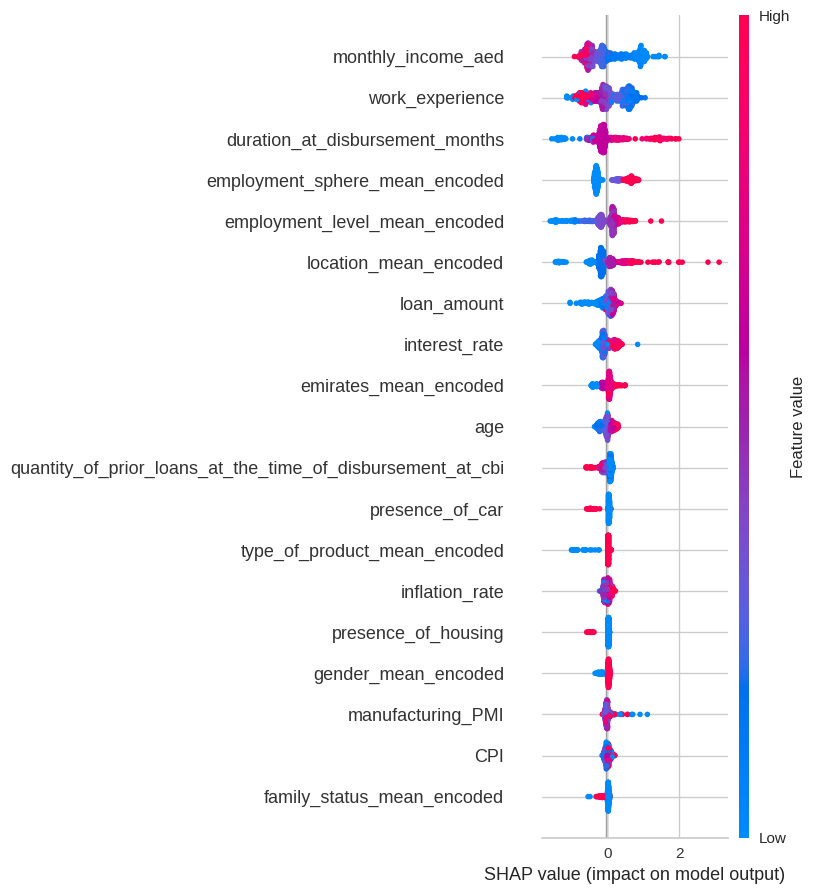

In [86]:
exp.interpret_model(trained_model_catboost)

In [87]:
blind = pd.read_excel('data/blind_set_new.xlsx')

In [88]:
blind.rename(columns={
    'Client ID': 'client_id', 
    'Loan currency': 'loan_currency', 
    'Loan amount': 'loan_amount',
    'Date of disbursement': 'date_of_disbursement', 
    'Date of closure based on contract':'date_of_closure_based_on_contract', 
    'Duration at disbursement (months)': 'duration_at_disbursement_months',
    'Interest rate': 'interest_rate',
    'Max DPD - 3 year': 'max_dpd_3_year',
    'Cumulative days of late payments throughout loan repayments': 'cumulative_days_of_late_payments_throughout_loan_repayments',
    'Quantity of prior loans (at the time of disbursement at CBI)': 'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
    'Type of product': 'type_of_product',
    'Status of loan': 'status_of_loan',
    'Location': 'location',
    'Emirates': 'emirates',
    'Gender': 'gender',
    'Age': 'age',
    'Family status': 'family_status',
    'Monthly income (AED)': 'monthly_income_aed',
    'Quantity of prior loans at CBI': 'quantity_of_prior_loans_at_cbi',
    'Employment sphere': 'employment_sphere',
    'Employment level': 'employment_level',
    'Work experience': 'work_experience',
    'Presence of car': 'presence_of_car',
    'Presence of housing': 'presence_of_housing',
    'Co-borrower': 'coborrower',
    'Collateral': 'collateral',
    'Top Up': 'top_up',
    'DSR': 'dsr'
    }, inplace=True)

In [89]:
blind['cmltv_90_bad'] = (blind['cumulative_days_of_late_payments_throughout_loan_repayments'] >= 90).astype(int)

In [90]:
blind['cmltv_90_bad'].value_counts()

0    2134
1     514
Name: cmltv_90_bad, dtype: int64

In [91]:
num_feats

['loan_amount',
 'duration_at_disbursement_months',
 'interest_rate',
 'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
 'age',
 'monthly_income_aed',
 'work_experience',
 'inflation_rate',
 'manufacturing_PMI',
 'presence_of_car',
 'presence_of_housing',
 'CPI',
 'location_mean_encoded',
 'emirates_mean_encoded',
 'gender_mean_encoded',
 'family_status_mean_encoded',
 'employment_sphere_mean_encoded',
 'collateral_mean_encoded',
 'type_of_product_mean_encoded',
 'employment_level_mean_encoded']

In [92]:
cat_feats = [
    'location',
    'emirates',
    'gender',
    'family_status',
    'employment_sphere',
    'collateral',
    'type_of_product',
    'employment_level'
]

In [93]:
# following columns don't have any values so they are dropped
blind.drop(columns=['Education level', "Quantity of client's dependents", 'loan_currency'], inplace=True)

In [94]:
# Adding monthly Macro-variables #
macro = pd.read_excel('data/UAE_Monthly1.xlsx')
macro['DateTime'] = macro['DateTime'].astype('datetime64')

blind['inflation_rate'] = np.zeros(len(blind))
blind['manufacturing_PMI'] = np.zeros(len(blind))

for i in blind.index:
    for j in macro.index:
        if blind.loc[i, 'date_of_disbursement'].year == macro.loc[j, 'DateTime'].year and blind.loc[i, 'date_of_disbursement'].month == macro.loc[j, 'DateTime'].month:
            blind.at[i, 'inflation_rate']    = macro.loc[j, 'Inflation Rate']
            blind.at[i, 'manufacturing_PMI'] = macro.loc[j, 'Manufacturing PMI']
            break

In [95]:
# Adding quarterly Macro-variables #
macro2 = pd.read_excel('data/UAE_quarter1.xlsx')
macro2['DateTime'] = macro2['DateTime'].astype('datetime64')

blind['CPI'] = [ np.nan for i in blind.index]

for i in blind.index:
    for j in macro2.index:
        if blind.loc[i, 'date_of_disbursement'].year == macro2.loc[j, 'DateTime'].year and blind.loc[i, 'date_of_disbursement'].month == macro2.loc[j, 'DateTime'].month:
            blind.at[i, 'CPI'] = macro2.loc[j, 'Consumer Price Index CPI']
            break

In [96]:
blind_macro = blind.copy()

In [97]:
blind_macro.insert(0, 'zypl_ID', range(0, len(blind_macro)))

In [98]:
def isnan(num):
    return num != num

# Converting Work experience feature to the months #
for i in blind_macro.index:
    it = blind_macro.loc[i, 'work_experience']
    years, months, gap, minus = 0, 0, False, False

    if isnan(it):
        continue
    
    # Extracting year and month from the string #
    for j in it :
        if j >= '0' and j <= '9' :
            if not gap :
                years = years*10 + int(j)
            else :
                months = months*10 + int(j)
        elif j == '-' :
            minus = True
            gap = True
        else :
            gap = True
    # Setting the new value to the DataFrame #
    if minus :
        months *= -1
        
    blind_macro.at[i, 'work_experience'] = int(years*12 + months)
    
blind_macro['work_experience'] = blind_macro['work_experience'].astype('float32')

In [99]:
# Target mean encoding #
cols = cat_feats

for col in cols:
    stats = train[target].groupby(train[col]).agg(['count', 'mean'])
    blind_macro[col+'_mean_encoded'] = blind_macro[col].copy()
    
    for i in blind_macro[col+'_mean_encoded'].unique():
        if i in stats.index:
            blind_macro[col+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)        

In [100]:
blind_macro.shape

(2648, 40)

In [101]:
# Removing classes that are in test set but not in train set #
for i in blind_macro.index :
    for col in cat_feats :
        if type(blind_macro[col+'_mean_encoded'][i]) == str:
            blind_macro.drop(i,inplace=True)
            break

In [102]:
blind_macro.shape

(2571, 40)

In [103]:
blind_macro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2571 entries, 1 to 2647
Data columns (total 40 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   zypl_ID                                                      2571 non-null   int64         
 1   client_id                                                    2571 non-null   int64         
 2   loan_amount                                                  2571 non-null   float64       
 3   date_of_disbursement                                         2571 non-null   datetime64[ns]
 4   date_of_closure_based_on_contract                            2571 non-null   datetime64[ns]
 5   duration_at_disbursement_months                              2571 non-null   int64         
 6   interest_rate                                                2571 non-null   float64       
 7   max_dpd_3_year 

---

In [104]:
final_model = exp.finalize_model(calibrated_catboost)

In [105]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions_blind = exp.predict_model(calibrated_catboost, raw_score=True, encoded_labels=True, data=blind_macro)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions_blind['prediction_label'] = (predictions_blind['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions_blind[target], predictions_blind['prediction_label']).ravel()
    auc = roc_auc_score(predictions_blind[target], predictions_blind['prediction_score_1'])
    accuracy = accuracy_score(predictions_blind[target], predictions_blind['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8596,0.8747,0.6210,0.6480,0.6342,0.5474,0.5476


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.575651,0.874716,1003.0,1064.0,27.0,477.0
1,0.15,0.717231,0.874716,1394.0,673.0,54.0,450.0
2,0.20,0.775963,0.874716,1576.0,491.0,85.0,419.0
3,0.25,0.810968,0.874716,1685.0,382.0,104.0,400.0
4,0.30,0.832750,0.874716,1757.0,310.0,120.0,384.0


In [106]:
# GET PERFORMANCE METRICS:
threshold = 0.2
predictions = exp.predict_model(calibrated_catboost, raw_score=True, encoded_labels=True, data=blind_macro)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('outputs/predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8596,0.8747,0.6210,0.6480,0.6342,0.5474,0.5476


{'0': {'precision': 0.9488260084286574,
       'recall': 0.7624576681180455,
       'f1-score': 0.8454935622317595,
       'support': 2067},
 '1': {'precision': 0.4604395604395604,
       'recall': 0.8313492063492064,
       'f1-score': 0.5926449787835927,
       'support': 504},
 'accuracy': 0.7759626604434072,
 'macro avg': {'precision': 0.7046327844341089,
               'recall': 0.7969034372336259,
               'f1-score': 0.7190692705076761,
               'support': 2571},
 'weighted avg': {'precision': 0.8530863080060572,
                  'recall': 0.7759626604434072,
                  'f1-score': 0.7959269787786766,
                  'support': 2571},
 'threshold': 0.2,
 'TN': 1576,
 'FP': 491,
 'FN': 85,
 'TP': 419,
 'AUC': 0.8747,
 'model NPL': 5.12,
 ' real NPL': 19.6,
 'approval rate': 64.61,
 'good correct': 76.25,
 'bad correct': 83.13}


In [107]:
predictions_blind['prediction_score_0'].to_csv('calibrated_catboost_pd.csv', index=None)

### Check some variables of train and blind set

In [108]:
num_feats[:-8]

['loan_amount',
 'duration_at_disbursement_months',
 'interest_rate',
 'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
 'age',
 'monthly_income_aed',
 'work_experience',
 'inflation_rate',
 'manufacturing_PMI',
 'presence_of_car',
 'presence_of_housing',
 'CPI']

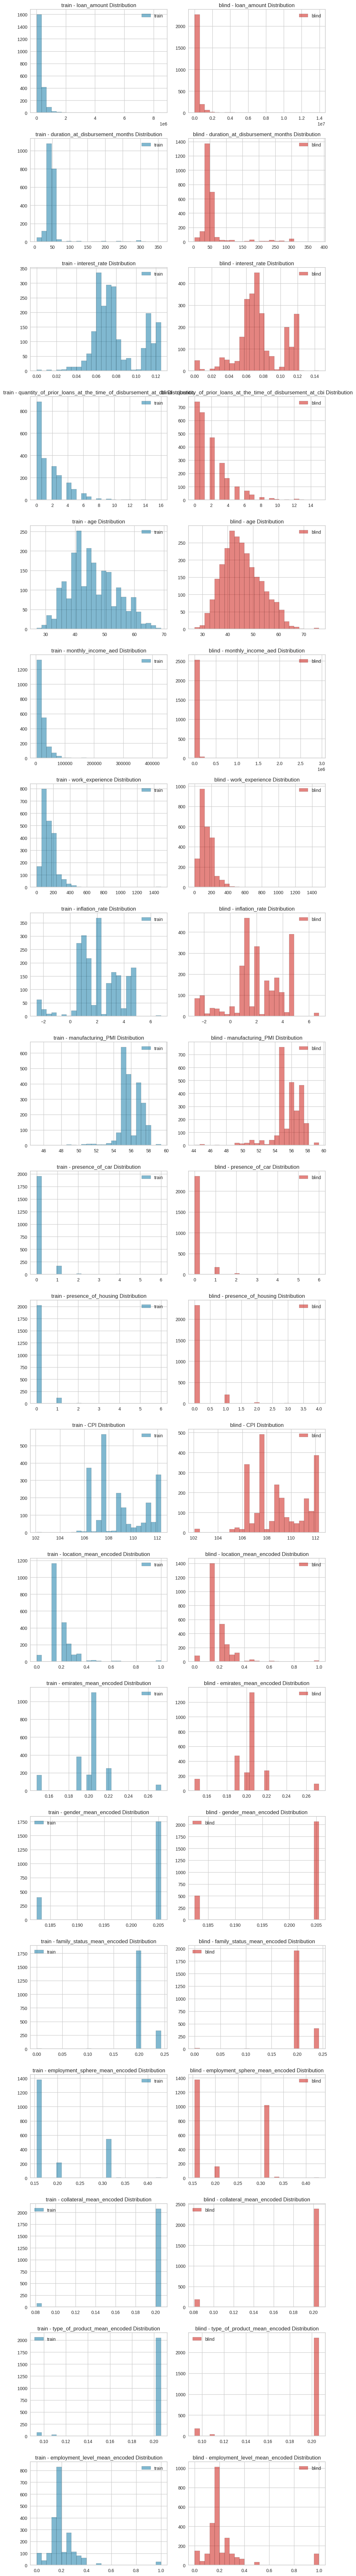

In [109]:
def compare_numeric_distributions(dataset1, dataset2, columns_to_compare):
    """
    Compare the distributions of numeric columns of two datasets using histograms.

    Args:
        dataset1 (pandas.DataFrame): The first dataset.
        dataset2 (pandas.DataFrame): The second dataset.
        columns_to_compare (list of str): A list of column names to compare.

    Returns:
        None
    """
    num_columns = len(columns_to_compare)
    fig, axes = plt.subplots(nrows=num_columns, ncols=2, figsize=(10, 4*num_columns))

    for i, column_name in enumerate(columns_to_compare):
        # Plot histogram for dataset1
        axes[i, 0].hist(dataset1[column_name], bins=25, alpha=0.5, color='b', label='train', edgecolor='k')
        axes[i, 0].set_title(f'train - {column_name} Distribution')
        axes[i, 0].legend()

        # Plot histogram for dataset2
        axes[i, 1].hist(dataset2[column_name], bins=25, alpha=0.5, color='r', label='blind', edgecolor='k')
        axes[i, 1].set_title(f'blind - {column_name} Distribution')
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

# Example usage:

# Define the columns to compare
columns_to_compare = num_feats

# Call the compare_numeric_distributions method
compare_numeric_distributions(train, blind_macro, columns_to_compare)


In [110]:
print(train.shape)
print(test.shape)
print(blind_macro.shape)

(2152, 40)
(527, 40)
(2571, 40)


### Compare test and blind set

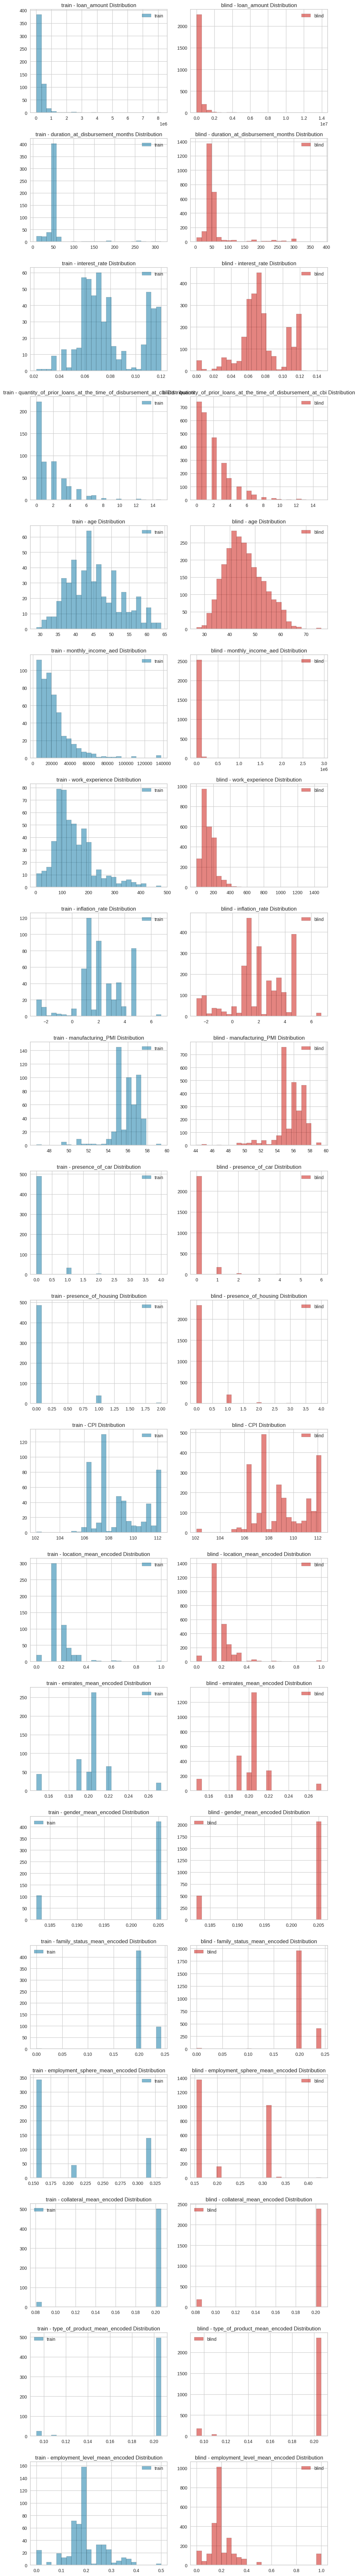

In [111]:
compare_numeric_distributions(test, blind_macro, columns_to_compare)

In [112]:
# Summary statistics for dataset 1
summary_train= train[num_feats].describe()

# Summary statistics for dataset 2
summary_blind = blind_macro[num_feats].describe()

# Print summary statistics
print("Train Summary Statistics:")
summary_train

Train Summary Statistics:


,loan_amount,duration_at_disbursement_months,interest_rate,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,age,monthly_income_aed,work_experience,inflation_rate,manufacturing_PMI,presence_of_car,presence_of_housing,CPI,location_mean_encoded,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded
count,2.152000e+03,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.00000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000
mean,2.988995e+05,53.352695,0.078748,1.673327,45.874535,22389.235841,148.009293,2.122756,55.987221,0.112918,0.066450,108.91027,0.201208,0.201208,0.201208,0.201208,0.201208,0.201208,0.201208,0.201208
std,3.859707e+05,34.477634,0.022750,2.057218,7.834531,20857.627160,86.204498,1.665606,1.233719,0.423376,0.310589,2.08286,0.102483,0.021384,0.008941,0.021857,0.069491,0.022674,0.023389,0.121472
min,1.500000e+04,6.000000,0.000000,0.000000,27.000000,3500.000000,3.000000,-2.500000,45.200000,0.000000,0.000000,102.09000,0.000000,0.147727,0.182500,0.000000,0.154460,0.081081,0.093333,0.000000
25%,1.250000e+05,48.000000,0.062500,0.000000,40.000000,10515.000000,93.000000,1.100000,55.100000,0.000000,0.000000,107.46000,0.158768,0.191601,0.205479,0.194892,0.154460,0.205486,0.206442,0.157434
50%,2.120000e+05,48.000000,0.072500,1.000000,45.000000,17500.000000,130.000000,2.100000,55.900000,0.000000,0.000000,108.62000,0.158768,0.204013,0.205479,0.194892,0.154460,0.205486,0.206442,0.184739
75%,3.642500e+05,52.000000,0.097000,3.000000,51.000000,26320.845000,189.250000,3.400000,57.000000,0.000000,0.000000,111.08000,0.231959,0.204771,0.205479,0.194892,0.313761,0.205486,0.206442,0.241379
max,8.508500e+06,358.000000,0.125000,16.000000,69.000000,429440.000000,1483.000000,6.770000,59.400000,6.000000,6.000000,112.29000,1.000000,0.272727,0.205479,0.242515,0.428571,0.205486,0.206442,1.000000


In [113]:
print("Blind Summary Statistics:")
summary_blind

Blind Summary Statistics:


,loan_amount,duration_at_disbursement_months,interest_rate,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,age,monthly_income_aed,work_experience,inflation_rate,manufacturing_PMI,presence_of_car,presence_of_housing,CPI,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded
count,2.571000e+03,2571.000000,2571.000000,2571.000000,2571.000000,2.571000e+03,2567.000000,2467.000000,2571.000000,2571.000000,2571.000000,2429.000000,2571.000000,2571.000000,2385.000000,2571.000000,2571.000000
mean,3.385124e+05,61.171140,0.075854,1.857643,45.554648,2.536718e+04,141.795090,1.995797,55.671684,0.101906,0.111241,108.971585,0.202407,0.200957,0.201760,0.196679,0.196808
std,5.379784e+05,50.081337,0.026082,2.038148,7.711810,6.757600e+04,84.199486,1.974716,1.711058,0.395156,0.377471,2.170175,0.020651,0.009138,0.023614,0.031913,0.031232
min,1.500000e+04,4.000000,0.000000,0.000000,27.000000,0.000000e+00,3.000000,-2.710000,44.100000,0.000000,0.000000,102.090000,0.147727,0.182500,0.000000,0.081081,0.093333
25%,1.227500e+05,48.000000,0.062500,0.000000,40.000000,1.000000e+04,90.000000,1.100000,55.100000,0.000000,0.000000,107.460000,0.201117,0.205479,0.194892,0.205486,0.206442
50%,2.100000e+05,48.000000,0.070000,1.000000,45.000000,1.711400e+04,123.000000,2.100000,55.900000,0.000000,0.000000,108.620000,0.204013,0.205479,0.194892,0.205486,0.206442
75%,3.689823e+05,55.000000,0.087500,3.000000,51.000000,2.643850e+04,186.000000,3.500000,57.000000,0.000000,0.000000,111.400000,0.204771,0.205479,0.194892,0.205486,0.206442
max,1.395000e+07,384.000000,0.145000,15.000000,76.000000,2.933226e+06,1483.000000,6.770000,59.400000,6.000000,4.000000,112.290000,0.272727,0.205479,0.242515,0.205486,0.206442


In [114]:
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp

# Example T-test
t_stat, p_value = ttest_ind(train['interest_rate'].dropna(), test['interest_rate'].dropna())
print("T-Test p-value:", f"{p_value:.10f}")

T-Test p-value: 0.4831890533


In [115]:
cat_feats

['location',
 'emirates',
 'gender',
 'family_status',
 'employment_sphere',
 'collateral',
 'type_of_product',
 'employment_level']

In [116]:
# Calculate Jaccard similarity
def jaccard_similarity_datasets(train, blind, cat_feats):
    comparings_two_cats = {}
    for categories in cat_feats:
        unique_categories1 = set(train[categories].unique())
        unique_categories2 = set(blind[categories].dropna().unique())

        intersection = len(unique_categories1.intersection(unique_categories2))
        union = len(unique_categories1.union(unique_categories2))

        jaccard_similarity = intersection / union
        comparings_two_cats[categories] = jaccard_similarity
    
    return comparings_two_cats


In [117]:
jaccard_similarity_datasets(train, blind_macro, cat_feats)

{'location': 0.8955223880597015,
 'emirates': 1.0,
 'gender': 1.0,
 'family_status': 1.0,
 'employment_sphere': 1.0,
 'collateral': 1.0,
 'type_of_product': 1.0,
 'employment_level': 0.900990099009901}

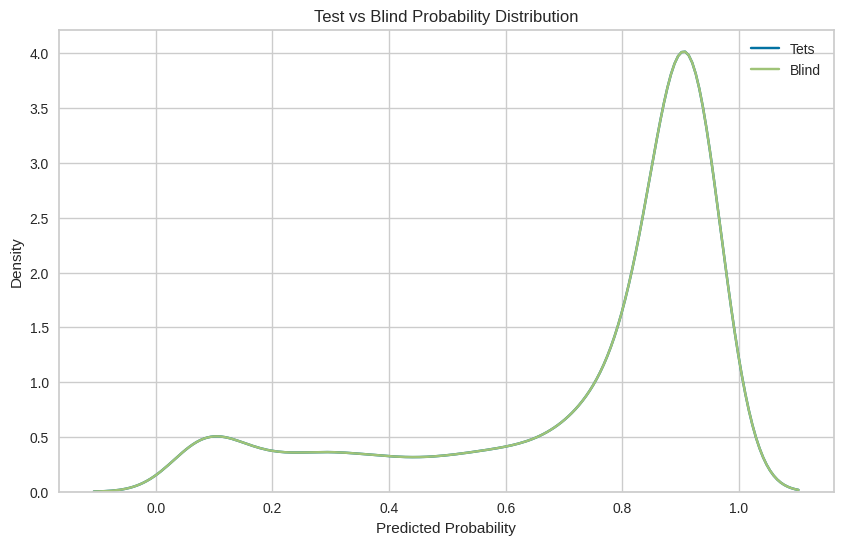

In [118]:

import seaborn as sns
# Plot the probability distribution for each class
plt.figure(figsize=(10, 6))

sns.distplot(predictions['prediction_score_0'], hist=False, label='Tets')
sns.distplot(predictions_blind['prediction_score_0'], hist=False, label='Blind')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Test vs Blind Probability Distribution')
plt.legend()
plt.show()

In [119]:
import scipy.stats as stats

def compare_datasets(train_data, blind_data, alpha=0.05):
    """
    Compare two datasets using the Kolmogorov-Smirnov test to determine if they come from the same distribution.

    Args:
        train_data (array-like): The first dataset (train data).
        blind_data (array-like): The second dataset (blind data).
        alpha (float): The significance level for the hypothesis test. Default is 0.05.

    Returns:
        bool: True if the datasets are likely to come from the same distribution, False otherwise.
    """
    # Perform the Kolmogorov-Smirnov test
    _, p_value = stats.ks_2samp(train_data, blind_data)
    
    # Compare the p-value to the significance level
    if p_value > alpha:
        return ("The datasets are likely from the same distribution.")
    else:
        return ("The datasets are likely from different distributions.") 


# train_data and blind_data are your actual datasets
compare_datasets(train['presence_of_housing'].values, blind['presence_of_housing'].values)

'The datasets are likely from different distributions.'

In [120]:
num_feats

['loan_amount',
 'duration_at_disbursement_months',
 'interest_rate',
 'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
 'age',
 'monthly_income_aed',
 'work_experience',
 'inflation_rate',
 'manufacturing_PMI',
 'presence_of_car',
 'presence_of_housing',
 'CPI',
 'location_mean_encoded',
 'emirates_mean_encoded',
 'gender_mean_encoded',
 'family_status_mean_encoded',
 'employment_sphere_mean_encoded',
 'collateral_mean_encoded',
 'type_of_product_mean_encoded',
 'employment_level_mean_encoded']

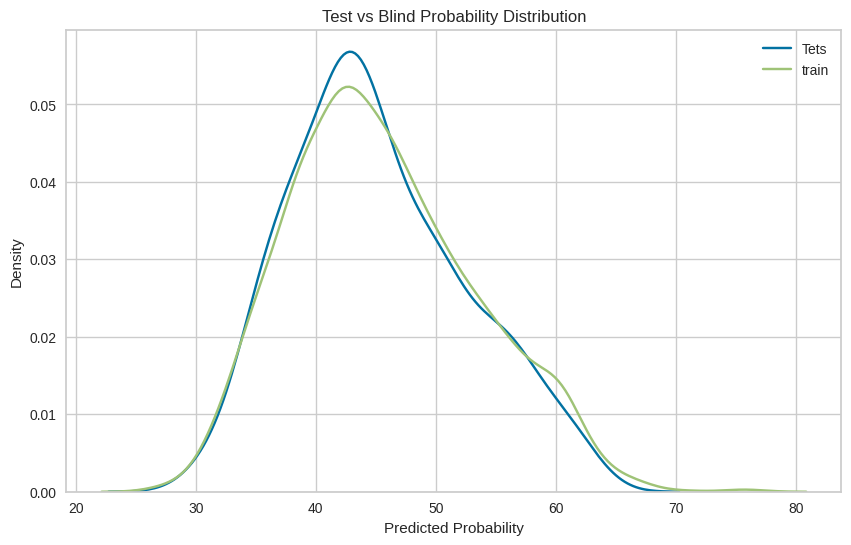

In [121]:

import seaborn as sns
# Plot the probability distribution for each class
plt.figure(figsize=(10, 6))

sns.distplot(test['age'], hist=False, label='Tets')
sns.distplot(blind['age'], hist=False, label='train')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Test vs Blind Probability Distribution')
plt.legend()
plt.show()

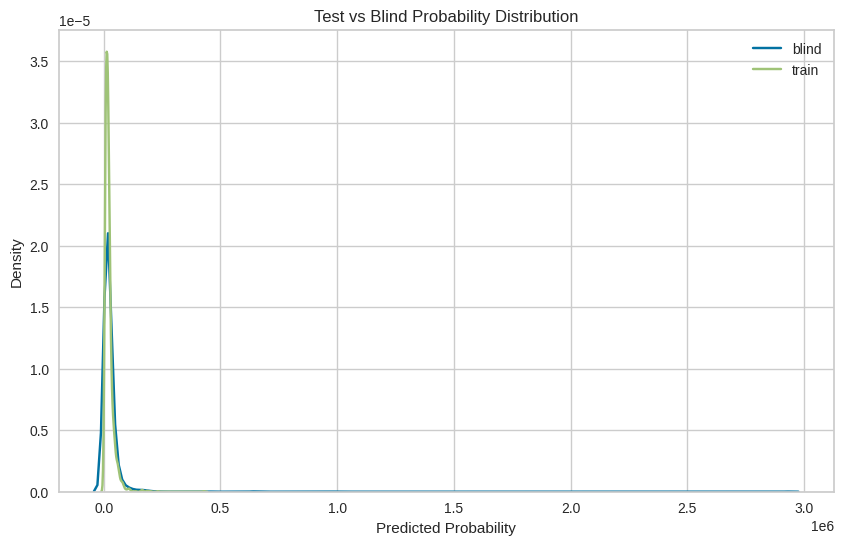

In [122]:

import seaborn as sns
# Plot the probability distribution for each class
plt.figure(figsize=(10, 6))

sns.distplot(blind_macro['monthly_income_aed'], hist=False, label='blind')
sns.distplot(train['monthly_income_aed'], hist=False, label='train')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Test vs Blind Probability Distribution')
plt.legend()
plt.show()

In [123]:
train.drop_duplicates()

,client_id,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,type_of_product,status_of_loan,location,emirates,gender,age,family_status,monthly_income_aed,quantity_of_prior_loans_at_cbi,employment_sphere,employment_level,work_experience,presence_of_car,presence_of_housing,coborrower,collateral,top_up,dsr,inflation_rate,manufacturing_PMI,CPI,max_90_bad,cmltv_90_bad,location_mean_encoded,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded
2921,8794,250000.0,2021-07-05,2025-08-01,49,0.0900,0,0,3,PERSONAL LOAN,Paid-off / Closed,PHILIPPINES,DXB Rigga Road BR,Male,43,MARRIED,15500.00,3,Personal salary,ENGINEER,91.0,0,0,No,No,Yes,47.48,0.0,54.0,106.62,0,0,0.231959,0.204013,0.205479,0.194892,0.154460,0.205486,0.206442,0.157434
1381,5622,217000.0,2017-08-03,2021-08-02,49,0.0800,0,0,6,PERSONAL LOAN,Paid-off / Closed,BANGLADESH,RAK Julphar BR,Male,45,MARRIED,12383.00,6,Personal others,OFFICER,155.0,0,0,No,No,Yes,49.54,0.8,57.3,107.46,0,0,0.272727,0.147727,0.205479,0.194892,0.204651,0.205486,0.206442,0.163043
1600,5887,225000.0,2017-11-08,2020-11-26,36,0.0675,0,0,2,PERSONAL LOAN,Paid-off / Closed,INDIA,DXB Rigga Road BR,Male,46,MARRIED,19647.00,2,Personal salary,SUPERVISOR,175.0,0,0,No,No,Yes,40.69,1.3,57.0,108.62,0,0,0.158768,0.204013,0.205479,0.194892,0.154460,0.205486,0.206442,0.275510
1771,6096,100000.0,2017-12-13,2020-12-28,36,0.0675,0,0,2,PERSONAL LOAN,Paid-off / Closed,INDIA,DXB Rigga Road BR,Male,60,MARRIED,17227.97,2,Personal salary,DRAUGHTSMAN,195.0,1,0,No,No,No,24.84,2.7,57.7,109.36,0,0,0.158768,0.204013,0.205479,0.194892,0.154460,0.205486,0.206442,0.277778
2486,9148,69500.0,2017-10-30,2021-11-28,48,0.1150,3,3,0,PERSONAL LOAN,Paid-off / Closed,INDIA,"Sharjah, Buhaira Branch",Male,40,MARRIED,6967.85,0,Personal salary,TECHNICIAN,99.0,0,0,No,No,No,46.92,2.1,55.9,106.42,0,0,0.158768,0.220884,0.205479,0.194892,0.154460,0.205486,0.206442,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,5942,350000.0,2017-09-25,2021-01-21,40,0.0625,0,0,4,PERSONAL LOAN,Paid-off / Closed,INDIA,"Sharjah, Buhaira Branch",Male,54,MARRIED,20200.00,4,Personal others,MANAGER,151.0,0,0,No,No,Yes,49.28,1.1,55.1,107.60,0,0,0.158768,0.220884,0.205479,0.194892,0.204651,0.205486,0.206442,0.184739
580,6386,200000.0,2017-10-15,2022-06-04,55,0.0750,939,939,1,PERSONAL LOAN,Charged off,INDIA,ADH Corniche BRH,Male,35,SINGLE,12000.00,1,Personal (Non business),OTHERS,95.0,0,0,No,No,No,40.30,2.1,55.9,106.42,1,1,0.158768,0.204771,0.205479,0.242515,0.313761,0.205486,0.206442,0.162162
2028,6555,630000.0,2017-10-24,2022-02-04,52,0.0575,0,0,3,PERSONAL LOAN,Paid-off / Closed,CANADA,ADH Corniche BRH,Male,58,MARRIED,35640.00,3,Personal (Non business),ENGINEER,168.0,1,0,No,No,Yes,46.07,2.1,55.9,106.42,0,0,0.000000,0.204771,0.205479,0.194892,0.313761,0.205486,0.206442,0.157434
1234,5464,245000.0,2018-02-12,2019-10-25,21,0.0650,0,0,3,PERSONAL LOAN,Paid-off / Closed,PHILIPPINES,ADH Corniche BRH,Female,64,MARRIED,25680.00,3,Personal others,MANAGER,192.0,0,0,No,No,Yes,42.78,4.5,55.1,112.12,0,0,0.231959,0.204771,0.182500,0.194892,0.204651,0.205486,0.206442,0.184739


In [124]:
blind.drop_duplicates()

,client_id,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,type_of_product,status_of_loan,location,emirates,gender,age,family_status,monthly_income_aed,quantity_of_prior_loans_at_cbi,employment_sphere,employment_level,work_experience,presence_of_car,presence_of_housing,coborrower,collateral,top_up,dsr,cmltv_90_bad,inflation_rate,manufacturing_PMI,CPI
0,5297,566060.30,2022-11-01,2031-10-27,108,0.050,4,8,4,PERSONAL LOAN,Active,UNITED ARAB EMIRATES,"Sharjah, Buhaira Branch",Male,35,MARRIED,6733.0,4,Personal salary,SUPPORTING SERVICES TO AIR TRANSPORT,15 Years 0 Months,0,0,No,No,Yes,NaN,0,NaN,54.4,NaN
1,5298,346000.00,2018-07-19,2022-08-01,49,0.000,396,518,1,PERSONAL LOAN,Charged off,INDIA,JUMEIRAH BRANCH,Male,39,MARRIED,18000.0,1,Personal (Non business),MANAGER,10 Years 5 Months,0,0,No,No,Yes,49.06,1,3.80,55.8,111.40
2,5299,78610.00,2017-10-17,2021-11-01,48,0.110,1461,1461,0,PERSONAL LOAN,Charged off,INDIA,DXB Rigga Road BR,Male,44,MARRIED,5615.0,0,Personal (Non business),EXECUTIVE,12 Years -2 Months,0,0,No,No,No,48.67,1,2.10,55.9,106.42
3,4933,216000.00,2018-01-08,2023-04-25,64,0.000,1009,1193,8,CAR LOAN,Charged off,UNITED ARAB EMIRATES,DXB Rigga Road BR,Female,46,MARRIED,1.0,8,Personal others,OTHER BUSINESSES - OTHER THAN LISTED,22 Years 7 Months,1,0,No,No,No,NaN,1,4.80,56.8,112.29
4,5300,90437.06,2018-07-19,2023-01-01,54,0.065,59,92,5,PERSONAL LOAN,Paid-off / Closed,PHILIPPINES,DXB Bur Dubai BR,Female,44,SINGLE,9000.0,5,Personal salary,OTHERS,7 Years 7 Months,0,0,No,No,Yes,NaN,1,3.80,55.8,111.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643,5293,75000.00,2017-10-10,2021-10-02,48,0.115,0,0,0,PERSONAL LOAN,Paid-off / Closed,PHILIPPINES,RAK Julphar BR,Female,38,SINGLE,7775.0,0,Personal (Non business),NURSE/MIDWIFE,7 Years 0 Months,0,0,No,No,No,28.02,0,2.10,55.9,106.42
2644,5294,145000.00,2018-04-02,2022-04-25,49,0.030,7,11,6,PERSONAL LOAN,Paid-off / Closed,INDIA,DXB Rigga Road BR,Male,38,SINGLE,1.0,6,Personal others,OTHERS,12 Years 5 Months,0,0,No,No,Yes,NaN,0,3.50,55.1,107.36
2645,5294,61949.08,2019-10-21,2023-04-30,43,0.000,715,952,7,PERSONAL LOAN,Charged off,INDIA,DXB Rigga Road BR,Male,38,SINGLE,1.0,7,Personal others,OTHERS,12 Years 5 Months,0,0,No,No,Yes,NaN,1,-2.18,51.1,108.35
2646,5295,117045.89,2018-11-27,2023-04-05,53,0.060,1152,1265,4,PERSONAL LOAN,Charged off,INDIA,JUMEIRAH BRANCH,Male,51,MARRIED,10000.0,4,Personal others,MANAGER,6 Years 5 Months,0,0,No,No,Yes,NaN,1,1.30,55.8,110.07


In [125]:
blind.shape

(2648, 31)

In [126]:
train.shape

(2152, 40)

In [127]:
train[train['client_id']==5293]

,client_id,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,type_of_product,status_of_loan,location,emirates,gender,age,family_status,monthly_income_aed,quantity_of_prior_loans_at_cbi,employment_sphere,employment_level,work_experience,presence_of_car,presence_of_housing,coborrower,collateral,top_up,dsr,inflation_rate,manufacturing_PMI,CPI,max_90_bad,cmltv_90_bad,location_mean_encoded,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded
1094,5293,75000.0,2017-10-10,2021-10-02,48,0.115,0,0,0,PERSONAL LOAN,Paid-off / Closed,PHILIPPINES,RAK Julphar BR,Female,38,SINGLE,7775.0,0,Personal (Non business),NURSE/MIDWIFE,84.0,0,0,No,No,No,28.02,2.1,55.9,106.42,0,0,0.231959,0.147727,0.1825,0.242515,0.313761,0.205486,0.206442,0.08


In [128]:
blind['client_id']

0       5297
1       5298
2       5299
3       4933
4       5300
        ... 
2643    5293
2644    5294
2645    5294
2646    5295
2647    5296
Name: client_id, Length: 2648, dtype: int64